In [1]:
# Thêm autoreload vào để tự động reload lại module nếu có thay đổi code trong module
%load_ext autoreload
%autoreload 2

import mediapipe as mp
import math
import numpy as np
import pandas as pd
import time as Time
import cv2
import copy
import warnings
warnings.filterwarnings('ignore')

import os, sys
sys.path.append(os.path.abspath(".."))
from utils.common import load_model, get_color_for_landmarks

# Drawing helpers
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

### Thực hiện việc dự đoán với các model Scikit learn có độ chính xác cao nhất

In [2]:
# Load model
# RF_model.pkl là sau điều chỉnh tham số
RF_model = load_model('./best_models/RF_model.pkl')

# Load input scaler
input_scaler = load_model("./best_models/input_scaler.pkl")

In [3]:
IMPORTANT_LMS = [
    "NOSE",
    "LEFT_SHOULDER",
    "RIGHT_SHOULDER",
    "LEFT_ELBOW",
    "RIGHT_ELBOW",
    "LEFT_WRIST",
    "RIGHT_WRIST",
    "LEFT_HIP",
    "RIGHT_HIP",
    "LEFT_KNEE",
    "RIGHT_KNEE",
    "LEFT_ANKLE",
    "RIGHT_ANKLE",
    "LEFT_HEEL",
    "RIGHT_HEEL",
    "LEFT_FOOT_INDEX",
    "RIGHT_FOOT_INDEX"
]

# Tạo các cột cho dữ liệu đầu vào
HEADERS = ["label"]
for landmark in IMPORTANT_LMS:
    for dim in ['x', 'y', 'z']:
        HEADERS.append(f"{landmark.lower()}_{dim}")

In [26]:
import os
import soundfile as sf

# Khởi tạo dictionary để lưu các đối tượng audio
error_types_audio = {}

# Thư mục chứa các file âm thanh
folder_path = "audios"
current_path = os.getcwd()

# Duyệt qua các file trong thư mục
for filename in os.listdir(folder_path):
    file_path = os.path.join(current_path, folder_path, filename)
    if os.path.isfile(file_path):
        data, samplerate = sf.read(file_path)
        filename = filename.replace(".wav", "")
        error_types_audio[filename] = (data, samplerate)

# In dictionary sau khi lưu
print(error_types_audio)


{'elbow_to_after': (array([ 6.10351562e-05, -3.05175781e-05,  0.00000000e+00, ...,
        3.05175781e-05,  0.00000000e+00,  1.52587891e-04]), 16000), 'elbow_to_front': (array([ 9.15527344e-05,  0.00000000e+00,  0.00000000e+00, ...,
        0.00000000e+00,  0.00000000e+00, -3.05175781e-05]), 16000), 'high_hip': (array([ 0.00000000e+00,  3.05175781e-05,  0.00000000e+00, ...,
        0.00000000e+00, -3.05175781e-05,  3.05175781e-05]), 16000), 'low_hip': (array([3.05175781e-05, 0.00000000e+00, 0.00000000e+00, ...,
       3.05175781e-05, 0.00000000e+00, 3.05175781e-05]), 16000), 'low_hip_elbow_to_after': (array([ 6.10351562e-05, -3.05175781e-05, -3.05175781e-05, ...,
        3.05175781e-05,  3.05175781e-05,  2.13623047e-04]), 16000), 'low_hip_elbow_to_front': (array([ 3.05175781e-05, -3.05175781e-05, -3.05175781e-05, ...,
        3.05175781e-05,  0.00000000e+00, -3.05175781e-05]), 16000), 'wrong_exercise.mp3': (array([ 1.17591594e-06, -6.26522342e-06, -3.29077420e-06, ...,
        4.151220

In [5]:
def extract_and_recalculate_landmarks(pose_landmarks):
    """
    Tịnh tiến thân người vào giữa bức hình, đồng thời dời lại trục toạ độ
    """
    hip_center_x = float((pose_landmarks[23].x + pose_landmarks[24].x) / 2)
    hip_center_y = float((pose_landmarks[23].y + pose_landmarks[24].y) / 2)

    new_center = (0.5, 0.5)
    delta_x = new_center[0] - hip_center_x
    delta_y = new_center[1] - hip_center_y

    data = []
    for landmark in IMPORTANT_LMS:
        # Lấy ra id của key point trên cơ thể người
        key_point_id = mp_pose.PoseLandmark[landmark].value

        key_point = pose_landmarks[key_point_id]
        key_point.x += delta_x - 0.5
        key_point.y += delta_y -0.5
        data.append([key_point.x, key_point.y, key_point.z])

    return np.array(data).flatten().tolist()


def extract_important_key_points(results) -> list:
    key_points = []

    for lm in IMPORTANT_LMS:
        # Lấy ra id của key point trên cơ thể người
        key_point_id = mp_pose.PoseLandmark[lm].value
        key_point = results.pose_landmarks.landmark[key_point_id]
        key_points.append([key_point.x, key_point.y, key_point.z])

    return np.array(key_points).flatten().tolist()

def rescale_frame(frame, percent=50):
    '''
    Rescale a frame to a certain percentage compare to its original frame
    '''
    width = int(frame.shape[1] * percent/ 100)
    height = int(frame.shape[0] * percent/ 100)
    dim = (width, height)
    return cv2.resize(frame, dim, interpolation =cv2.INTER_AREA)

In [6]:
def get_class(encode_label: float):
    return {
        0: "C",
        1: "W"
    }.get(encode_label, "Unknown")

### Dùng phương pháp hình học để xác định lỗi sai

In [7]:
# xác định chiều dài và chiều rộng của bức ảnh
def get_image_size(image):
    return image.shape[1], image.shape[0]

In [8]:
def calculate_angle(a, b, c, size_of_image):
    # Lấy tọa độ của 3 điểm
    a = (a[0] * size_of_image[0], a[1] * size_of_image[1])
    b = (b[0] * size_of_image[0], b[1] * size_of_image[1])
    c = (c[0] * size_of_image[0], c[1] * size_of_image[1])

    # Tính góc giữa 3 điểm
    angle = math.degrees(math.atan2(c[1] - b[1], c[0] - b[0]) - math.atan2(a[1] - b[1], a[0] - b[0]))
    
    # Chuyển góc về khoảng từ 0 đến 360 độ
    if angle < 0:
        angle += 360
    return angle

In [35]:
def define_error(key_points, image_size):
    error = []

    # Trung điểm của 2 vai
    shoulder_center = ((key_points.left_shoulder_x[0] + key_points.right_shoulder_x[0]) / 2,
                        (key_points.left_shoulder_y[0] + key_points.right_shoulder_y[0]) / 2)
    hip_center = ((key_points.left_hip_x[0] + key_points.right_hip_x[0]) / 2,
                    (key_points.left_hip_y[0] + key_points.right_hip_y[0]) / 2)
    
    # Góc giữa trung điểm 2 vai và trung điểm 2 hông so với trục x
    body_vector = (hip_center[0] - shoulder_center[0], hip_center[1] - shoulder_center[1])
    angle = math.degrees(math.atan2(body_vector[1], body_vector[0]))
    print(angle)
    if angle > 40:
        return "wrong exercise"

    if (key_points.nose_x[0] > 0):
        angle = calculate_angle((key_points.right_shoulder_x[0], key_points.right_shoulder_y[0]), 
                        (key_points.right_hip_x[0], key_points.right_hip_y[0]), 
                        (key_points.right_ankle_x[0], key_points.right_ankle_y[0]), 
                        image_size)
    else:
        angle = calculate_angle((key_points.left_ankle_x[0], key_points.left_ankle_y[0]), 
                        (key_points.left_hip_x[0], key_points.left_hip_y[0]), 
                        (key_points.left_shoulder_x[0], key_points.left_shoulder_y[0]),
                        image_size)

    if angle < 160:
        error.append("high hip")
    elif angle > 190:
        error.append("low hip")

    if (key_points.nose_x[0] > 0):
        angle = calculate_angle((key_points.right_shoulder_x[0], key_points.right_shoulder_y[0]),
                            (key_points.right_elbow_x[0], key_points.right_elbow_y[0]),
                            (key_points.right_wrist_x[0], key_points.right_wrist_y[0]),
                            image_size)
    else:
        angle = calculate_angle((key_points.left_wrist_x[0], key_points.left_wrist_y[0]),
                            (key_points.left_elbow_x[0], key_points.left_elbow_y[0]),
                            (key_points.left_shoulder_x[0], key_points.left_shoulder_y[0]),
                            image_size)
    
    if angle < 65:
        error.append("elbow to front")
    elif angle > 105:
        error.append("elbow to after")

    if error == []:
        return "Unknown"
    else:
        return ", ".join(error)

In [10]:
is_playing = False

In [11]:
import threading
import sounddevice as sd

def play_audio(data, samplerate):
    global is_playing
    is_playing = True
    sd.play(data, samplerate)
    sd.wait()
    is_playing = False

# Hàm bắt đầu một luồng để phát âm thanh
def start_audio_thread(data, samplerate):
    threading.Thread(target=play_audio, args=(data, samplerate,), daemon=True).start()

In [12]:
def plank_detection_offline(video_path, prediction_probability_threshold = 0.5):
    cap = cv2.VideoCapture(video_path if video_path else 0)
    current_class = "Unknown"

    # Số frame được bỏ qua
    image_width, image_height = 0, 0
    frame_skip = 2
    frame_count = 0
    result_frames = []

    estimate_time_handler_matrix = np.array(["time", "frame_index", "label", "error"]).reshape(1, 4)
    
    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            ret, image = cap.read()

            if not ret:
                print("Ignoring empty camera frame.")
                break
            
            time_flag = Time.time()
            
            frame_count += 1

            # Bỏ qua frame nếu không phải frame được xử lý
            if frame_count % frame_skip != 0:
                continue

            image_width, image_height = get_image_size(image)
            if image_width > 1000:
                image = rescale_frame(image, percent=50)
                image_width, image_height = get_image_size(image)

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = pose.process(image)

            if not results.pose_landmarks:
                print("No human found")
                continue

            initial_pose_landmarks = copy.deepcopy(results.pose_landmarks)
            image.flags.writeable = True

            # Cần khôi phục lại màu gốc của ảnh
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # Get landmarks
            try:
                key_points = extract_and_recalculate_landmarks(results.pose_landmarks.landmark)
                X = pd.DataFrame([key_points], columns=HEADERS[1:])
                error = define_error(X, get_image_size(image))
                image_size = get_image_size(image)
                if (X.nose_x[0] > 0):
                    angle = calculate_angle((X.right_shoulder_x[0], X.right_shoulder_y[0]),
                                        (X.right_elbow_x[0], X.right_elbow_y[0]),
                                        (X.right_wrist_x[0], X.right_wrist_y[0]),
                                        image_size)
                else:
                    angle = calculate_angle((X.left_wrist_x[0], X.left_wrist_y[0]),
                                        (X.left_elbow_x[0], X.left_elbow_y[0]),
                                        (X.left_shoulder_x[0], X.left_shoulder_y[0]),
                                        image_size)
                X = input_scaler.transform(X)

                predicted_class = RF_model.predict(X)[0]
                predicted_class = get_class(RF_model.predict(X)[0])
                prediction_probability_max = RF_model.predict_proba(X)[0].max()

                if prediction_probability_max >= prediction_probability_threshold:
                    current_class = predicted_class
                else:
                    current_class = "Unknown"

                if current_class == "W" and error == "Unknown":
                    current_class = "C"
                    error = "None"

                colors = get_color_for_landmarks(current_class)
                mp_drawing.draw_landmarks(
                        image,
                        initial_pose_landmarks,
                        mp_pose.POSE_CONNECTIONS,
                        mp_drawing.DrawingSpec(color=colors[0], thickness=2, circle_radius=2),
                        mp_drawing.DrawingSpec(color=colors[1], thickness=2, circle_radius=1),
                    )

                cv2.rectangle(image, (0, 0), (750, 60), (245, 117, 16), -1)

                # Display error
                cv2.putText(image, "ERROR", (180, 12), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                if (current_class == "Unknown"):
                    cv2.putText(image, "Unknown", (180, 40), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                elif (current_class == "W"):
                    cv2.putText(image, error, (180, 40), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                else:
                    cv2.putText(image, "None", (180, 40), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

                # Display class
                cv2.putText(image, "CLASS", (95, 12), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                cv2.putText(image, current_class, (110, 40), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

                # Display probability
                cv2.putText(image, "PROB", (15, 12), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                cv2.putText(image, str(round(prediction_probability_max, 2)), (10, 40), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

                # Lưu frame vào để phục vụ cho việc xuất video
                result_frames.append(image)

                estimate_time_handler_matrix = np.vstack([estimate_time_handler_matrix, [Time.time() - time_flag, frame_count, current_class, error]])                    

            except Exception as e:
                print(f"Error: {e}")

            cv2.imshow("CV2", image)

            # Nhấn q để thoát
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        pd.DataFrame(estimate_time_handler_matrix[1:], 
                            columns=estimate_time_handler_matrix[0]).to_csv("estimate_time_handler_matrix.csv", index=False)
        cap.release()
        cv2.destroyAllWindows()

    # Xuất video
    out = cv2.VideoWriter(
        "output.mp4", cv2.VideoWriter_fourcc(*"H264"), 15, (image_width, image_height)
    )

    # Ghi các frame vào video
    for frame in result_frames:
        out.write(frame)

    # Giải phóng VideoWriter object
    out.release()

    return result_frames

In [22]:
def plank_detection_realtime(video_path, prediction_probability_threshold = 0.5):
    cap = cv2.VideoCapture(video_path if video_path else 0)
    current_class = "Unknown"

    # Số frame được bỏ qua
    frame_skip = 2
    frame_count = 0
    image_width, image_height = 0, 0

    result_frames = []
    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            ret, image = cap.read()

            if not ret:
                print("Ignoring empty camera frame.")
                break

            frame_count += 1

            # Bỏ qua frame nếu không phải frame được xử lý
            if frame_count % frame_skip != 0:
                continue

            image_width, image_height = get_image_size(image)
            if image_width > 1000:
                image = rescale_frame(image, percent=50)
                image_width, image_height = get_image_size(image)

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            results = pose.process(image)

            if not results.pose_landmarks:
                print("No human found")
                continue

            image.flags.writeable = True

            # Cần khôi phục lại màu gốc của ảnh
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            # Get landmarks
            try:
                key_points = extract_and_recalculate_landmarks(results.pose_landmarks.landmark)
                X = pd.DataFrame([key_points], columns=HEADERS[1:])

                image_size = get_image_size(image)
                if (X.nose_x[0] > 0):
                    angle = calculate_angle((X.right_shoulder_x[0], X.right_shoulder_y[0]),
                                        (X.right_elbow_x[0], X.right_elbow_y[0]),
                                        (X.right_wrist_x[0], X.right_wrist_y[0]),
                                        image_size)
                else:
                    angle = calculate_angle((X.left_wrist_x[0], X.left_wrist_y[0]),
                                        (X.left_elbow_x[0], X.left_elbow_y[0]),
                                        (X.left_shoulder_x[0], X.left_shoulder_y[0]),
                                        image_size)
    
                error = define_error(X, get_image_size(image))
                
                X = input_scaler.transform(X)

                predicted_class = RF_model.predict(X)[0]
                predicted_class = get_class(RF_model.predict(X)[0])
                prediction_probability_max = RF_model.predict_proba(X)[0].max()

                if prediction_probability_max >= prediction_probability_threshold:
                    current_class = predicted_class
                else:
                    current_class = "Unknown"
                
                if current_class == "W" and error == "Unknown":
                    current_class = "C"
                    error = "None"
                
                error_type = error.replace(", ", "_").replace(" ", "_").lower()
                if current_class == "W" and error_type in error_types_audio and not is_playing:
                    data, samplerate = error_types_audio[error_type]
                    start_audio_thread(data, samplerate)

                cv2.rectangle(image, (0, 0), (750, 60), (245, 117, 16), -1)

                cv2.putText(image, "ERROR", (180, 12), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                if (current_class == "Unknown"):
                    cv2.putText(image, "Unknown", (180, 40), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                elif (current_class == "W"):
                    cv2.putText(image, error, (180, 40), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                else:
                    cv2.putText(image, "None", (180, 40), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

                # Display class
                cv2.putText(image, "CLASS", (95, 12), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                angle = round(angle, 2)
                cv2.putText(image, current_class, (110, 40), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

                # Display probability
                cv2.putText(image, "PROB", (15, 12), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)
                cv2.putText(image, str(round(prediction_probability_max, 2)), (10, 40), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

                # Lưu frame vào để phục vụ cho việc xuất video
                result_frames.append(image)

            except Exception as e:
                print(f"Error: {e}")

            cv2.imshow("CV2", image)

            # Nhấn q để thoát
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        cap.release()
        cv2.destroyAllWindows()

    # Xuất video
    print(image_width, image_height)
    out = cv2.VideoWriter(
        "output.mp4", cv2.VideoWriter_fourcc(*"H264"), 20, (image_width, image_height)
    )

    # Ghi các frame vào video
    for frame in result_frames:
        out.write(frame)

    out.release()
    return result_frames

In [28]:
result_frames = plank_detection_offline("testing02.mp4")

In [ ]:
result_frames = plank_detection_realtime("testing05.mp4")

In [16]:
analyze = pd.read_csv("estimate_time_handler_matrix.csv")

analyze.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         265 non-null    float64
 1   frame_index  265 non-null    int64  
 2   label        265 non-null    object 
 3   error        252 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 8.4+ KB


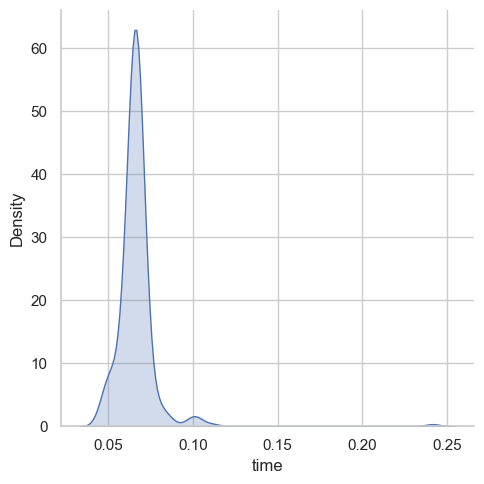

In [17]:
import seaborn as sns

sns.set_theme(style="whitegrid")
sns.displot(analyze, x="time", kind="kde", fill=True)

In [18]:
analyze["time"].mean()

0.06650266647338862

In [19]:
analyze["time"].max()

0.2414817810058593

In [20]:
analyze["time"].min()

0.0465879440307617